# Assessment of the resolution of SLSTR AOD and Fine_AOD (1°) satellite data for monitoring Hunga Tonga volcanic eruption
&nbsp;

Production date: 30-09-2024

Produced by: University of Salerno ([UNISA](https://web.unisa.it/en/university)- Fabio Madonna and Faezeh Karimian)

## 🌍 Use case: Investigating volcanic eruptions using satellite observations

## ❓ Quality assessment question
**• Is the resolution of satellite-derived AOD and Fine_AOD estimates sufficient to study the transport of aerosol particles from Hunga Tonga volcanic eruption?**

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note


* The daily AOD maps capture the onset and subsequent dispersion of the plume during the days following the eruption, clearly showing its expansion across the South Pacific and the gradual dilution of aerosol loading over time.

* The fine-coarse fraction estimates show a physically coherent shift in aerosol size distribution: coarse particles increase immediately after the eruption.

* Some AOD retrievals near the volcano are missing on certain days, likely because of cloud cover or intense volcanic ash concentrations. 
```

## 📋 Methodology

The methodology adopted for the analysis of the Hunga Tonga eruption is split into the following steps:

[](section-1)  
- Import all required libraries
- Select the datasets used in the study
- Define the study area around the Hunga Tonga volcano and the analysis period


[](section-2)  
- Load daily AOD data
- Subset AOD to common AOI (±HALFWIN) 
- Prepare data for 9-panel AOD mapping
- Function to generate 9-panel daily AOD maps

[](section-3)  
- 9-panel map of daily AOD550 before and after the Hunga Tonga eruption (13–21 January 2022)
- 9-panel map of daily Fine-mode AOD550 before and after the Hunga Tonga eruption (13–21 January 2022)
- comparison of fine- and coarse-mode aerosol fractions before and after the eruption

[](section-4)  
- Take-Home Messages

## 📈 Analysis and results
(section-1)=
### 1. Choose the data to use and set up the code

#### Import all required libraries

In this section, we import all the relevant packages required to run the notebook.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import calendar
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from c3s_eqc_automatic_quality_control import download

#### Select the datasets used in the study

In [3]:
# AOD folder (daily files)
AOD_FOLDER = "./aod_daily_data"

request = {
    "time_aggregation": "daily_average",
    "variable": ["aerosol_optical_depth"],
    "sensor_on_satellite": ["slstr_on_sentinel_3a"], 
    "algorithm": "ens",
    "version": "v2_3",
    "format": "zip"
}

#### Define the study area around the Hunga Tonga volcano and the analysis period

In [10]:
VOLCANO = {"lat": -20.55, "lon": -175.38}
HALFWIN = 1.0   # e.g. ±3° around the volcano
# Analysis period
START_DATE = pd.Timestamp("2022-01-13")
END_DATE  = pd.Timestamp("2022-01-21")

(section-2)=
### Data loading and preparation

#### Load daily AOD data

In [11]:
file_list = sorted([
    os.path.join(AOD_FOLDER, f)
    for f in os.listdir(AOD_FOLDER)
    if f.endswith(".nc")
])

df_list = []
for file in file_list:
    ds = xr.open_dataset(file)
    # keep only the required variables
    ds = ds[["AOD550", "FM_AOD550", "latitude", "longitude"]]
    # timestamp from file name (YYYYMMDD)
    timestamp = pd.to_datetime(os.path.basename(file)[:8], format="%Y%m%d")
    ds = ds.expand_dims({"time": [timestamp]})
    df = ds.to_dataframe().reset_index()
    df_list.append(df)

aod_df = pd.concat(df_list, ignore_index=True)
aod_df.replace(-999.0, np.nan, inplace=True)
aod_df["time"] = pd.to_datetime(aod_df["time"])
aod_df = aod_df.sort_values("time")

print("AOD dataframe loaded with shape:", aod_df.shape)
aod_df.head()

AOD dataframe loaded with shape: (2268000, 5)


,time,latitude,longitude,AOD550,FM_AOD550
0,2022-01-01,-89.5,-179.5,NaN,NaN
43192,2022-01-01,29.5,172.5,0.187939,0.141549
43193,2022-01-01,29.5,173.5,0.208070,0.157441
43194,2022-01-01,29.5,174.5,0.089787,0.064093
43195,2022-01-01,29.5,175.5,0.100026,0.066048


#### Subset AOD550 and Fine_AOD550 to common AOI (±HALFWIN) 

In [12]:
def wrap180(lon: float) -> float:
    """Convert longitude from [0, 360) to [-180, 180)."""
    return ((lon + 180) % 360) - 180

def subset_aoi_antimeridian(df, lat0, lon0, halfwin):
    """
    Subset df around (lat0, lon0) with width 2*halfwin, handling the antimeridian.
    """
    df = df.copy()
    df["longitude"] = df["longitude"].apply(wrap180)
    lon0 = wrap180(lon0)

    lat_mask = df["latitude"].between(lat0 - halfwin, lat0 + halfwin)

    west, east = lon0 - halfwin, lon0 + halfwin
    if west <= east:
        lon_mask = df["longitude"].between(west, east)
    else:
     
        lon_mask = (df["longitude"] >= west) | (df["longitude"] <= east)

    return df[lat_mask & lon_mask]

#  subset around volcano for BOTH AOD and fine-mode AOD 
aod_aoi = subset_aoi_antimeridian(
    aod_df,
    VOLCANO["lat"],
    VOLCANO["lon"],
    HALFWIN
)

#  daily mean over AOI for AOD550 and FM_AOD550 
daily_aod = (
    aod_aoi
    .dropna(subset=["AOD550", "FM_AOD550"])   # keep rows where both exist
    .groupby("time")[["AOD550", "FM_AOD550"]] # work on both columns
    .mean()
    .sort_index()
)

print("Daily AOD and fine-mode AOD over AOI:")
display(daily_aod)


Daily AOD and fine-mode AOD over AOI:


,AOD550,FM_AOD550
time,,
2022-01-01,0.063557,0.044091
2022-01-13,0.130747,0.088537
2022-01-16,0.141580,0.080177
2022-01-17,0.088671,0.061638
2022-01-20,0.149817,0.078330
2022-01-24,0.114521,0.068941
2022-02-01,0.072149,0.045140


#### Prepare data for 9-panel AOD mapping

In [ ]:

LAT_HW, LON_HW = 7.5, 15.0          # plotting window 

aod = aod_df.copy()
aod["time"]      = pd.to_datetime(aod["time"])
aod["longitude"] = aod["longitude"].apply(wrap180)

aod_9 = aod[(aod["time"] >= START_DATE) & (aod["time"] <= END_DATE)].copy()

# list of days 
days_9 = pd.to_datetime(
    aod_9["time"].dropna().sort_values().dt.floor("D").unique()
)
print("Days in 9-panel period:", [d.date() for d in days_9])

#### Function to generate 9-panel daily AOD maps

In [31]:
def plot_9panel_aod(aod_df, days, varname, label, cmap="YlOrRd"):
    """
    Make a 3×3 panel of daily maps for `varname` over the given days.
    aod_df:   dataframe with time, lat, lon, varname
    days:     list/array of 9 dates
    varname:  column name ('AOD550' or 'FM_AOD550')
    label:    used in title and colorbar label
    """
    vals = []
    for d in days:
        sub = aod_df[aod_df["time"].dt.floor("D") == d][varname].dropna()
        if len(sub) > 0:
            vals.append(sub.values)
    allv = np.concatenate(vals) if vals else np.array([0.0, 0.5])
    allv = allv[np.isfinite(allv)]
    vmin = max(0.0, np.percentile(allv, 5)) if allv.size else 0.0
    vmax = max(vmin + 0.01, np.percentile(allv, 95)) if allv.size else 0.5

    central = wrap180(VOLCANO["lon"])
    proj = ccrs.PlateCarree(central_longitude=central)
    crs_data = ccrs.PlateCarree()

    fig, axes = plt.subplots(
        3, 3, figsize=(16, 9),
        subplot_kw={"projection": proj}
    )
    axes = axes.flatten()

    def is_bottom(i): return i // 3 == 2
    def is_left(i):   return i % 3 == 0

    mesh = None
    for i, (ax, day) in enumerate(zip(axes, days)):
        sub = aod_df[aod_df["time"].dt.floor("D") == day].dropna(subset=[varname])

        ax.set_title(str(day.date()), fontsize=11, pad=6)  # small extra padding
        ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
        ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.25)

        west, east = VOLCANO["lon"] - LON_HW, VOLCANO["lon"] + LON_HW
        south, north = VOLCANO["lat"] - LAT_HW, VOLCANO["lat"] + LAT_HW
        ax.set_extent([west, east, south, north], crs=crs_data)

        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray",
                          alpha=0.4, linestyle="--")
        gl.xlocator = mticker.MultipleLocator(5)
        gl.ylocator = mticker.MultipleLocator(2.5)
        gl.xformatter = LongitudeFormatter(number_format=".0f")
        gl.yformatter = LatitudeFormatter(number_format=".1f")
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = is_bottom(i)
        gl.left_labels = is_left(i)
        gl.xlabel_style = {"size": 9}
        gl.ylabel_style = {"size": 9}

        if sub.empty:
            ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
                    ha="center", va="center", color="dimgray")
            continue

        grid = (sub.pivot_table(index="latitude", columns="longitude",
                                values=varname, aggfunc="mean")
                .sort_index(ascending=True)
                .sort_index(axis=1))

        lats = grid.index.values
        lons = grid.columns.values
        dlat = np.median(np.diff(lats)) if len(lats) > 1 else 1.0
        dlon = np.median(np.diff(lons)) if len(lons) > 1 else 1.0
        lat_edges = np.concatenate(([lats[0]-dlat/2],
                                    (lats[:-1]+lats[1:])/2,
                                    [lats[-1]+dlat/2]))
        lon_edges = np.concatenate(([lons[0]-dlon/2],
                                    (lons[:-1]+lons[1:])/2,
                                    [lons[-1]+dlon/2]))

        mesh = ax.pcolormesh(
            lon_edges, lat_edges, grid.values,
            transform=crs_data, shading="auto",
            vmin=vmin, vmax=vmax, cmap=cmap
        )

        ax.plot(VOLCANO["lon"], VOLCANO["lat"], marker="*", ms=9,
                color="cyan", mec="k", mew=0.8, transform=crs_data)

    # hide unused axes
    for ax in axes[len(days):]:
        ax.axis("off")

    # shared colorbar
    if mesh is not None:
        cax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
        cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
        cb.set_label(label, fontsize=11)
        cb.ax.tick_params(labelsize=9)

    fig.suptitle(f"Daily {label} maps ({days[0].date()} to {days[-1].date()})",
                 fontsize=14, weight="bold")

    # increase space between panels (horizontal & vertical)
    fig.subplots_adjust(left=0.05, right=0.98, bottom=0.12, top=0.9,
                        wspace=0.25, hspace=0.30)

    plt.show()


(section-3)=
### Plot and describe the results

#### spatial availability of aod retrievals 15 days before and 15 days after the eruption

This section shows, for each grid cell, how many days have valid AOD550 retrievals before and after the 15 January 2022 Hunga Tonga eruption, and visualises these counts as two maps. The comparison highlights where and how often the satellite product successfully retrieves AOD in the eruption region, revealing both pre-existing coverage patterns and changes associated with the volcanic plume and retrieval limitations near the source.

/data/wp5/.tmp/ipykernel_2073273/2432905076.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.16, 1, 0.95])


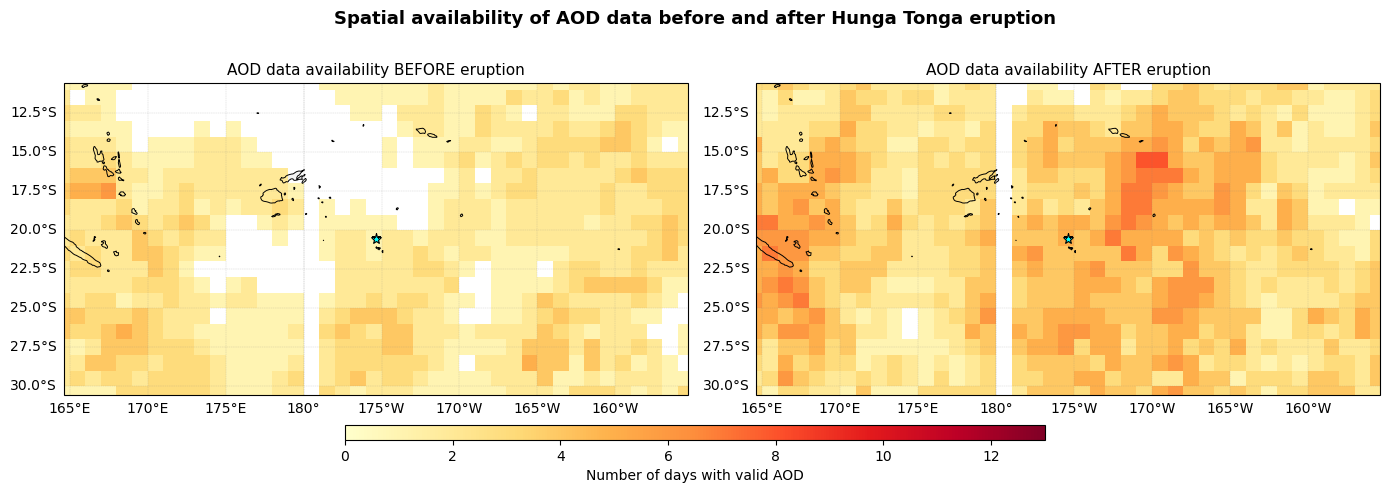

In [30]:

ERUPTION = pd.Timestamp("2022-01-15")
VOLCANO  = {"lat": -20.55, "lon": -175.38}

def wrap180(lon):
    return ((lon + 180) % 360) - 180

aod = aod_df.copy()
aod["time"]      = pd.to_datetime(aod["time"])
aod["longitude"] = aod["longitude"].apply(wrap180)

# split before / after eruption
aod_before = aod[aod["time"] < ERUPTION].dropna(subset=["AOD550"])
aod_after  = aod[aod["time"] > ERUPTION].dropna(subset=["AOD550"])

-
def availability_grid(df):
    # count valid pixels per (lat, lon)
    counts = (
        df.groupby(["latitude", "longitude"])["AOD550"]
          .count()
          .unstack("longitude")
    )
 
    counts = counts.sort_index(ascending=True).sort_index(axis=1)
    return counts

grid_before = availability_grid(aod_before)
grid_after  = availability_grid(aod_after)


vmax = max(grid_before.max().max(), grid_after.max().max())
vmin = 0


def cell_edges(grid):
    lats = grid.index.values
    lons = grid.columns.values
    dlat = np.median(np.diff(lats)) if len(lats) > 1 else 1.0
    dlon = np.median(np.diff(lons)) if len(lons) > 1 else 1.0
    lat_edges = np.r_[lats[0]-dlat/2, (lats[:-1]+lats[1:])/2, lats[-1]+dlat/2]
    lon_edges = np.r_[lons[0]-dlon/2, (lons[:-1]+lons[1:])/2, lons[-1]+dlon/2]
    return lon_edges, lat_edges

lon_edges_b, lat_edges_b = cell_edges(grid_before)
lon_edges_a, lat_edges_a = cell_edges(grid_after)

central = wrap180(VOLCANO["lon"])
proj = ccrs.PlateCarree(central_longitude=central)
crs_data = ccrs.PlateCarree()

fig, axes = plt.subplots(
    1, 2, figsize=(14, 5),
    subplot_kw={"projection": proj}
)
titles = ["AOD data availability BEFORE eruption",
          "AOD data availability AFTER eruption"]
grids  = [grid_before, grid_after]
lon_edges_list = [lon_edges_b, lon_edges_a]
lat_edges_list = [lat_edges_b, lat_edges_a]

for ax, title, grid, lon_edges, lat_edges in zip(
        axes, titles, grids, lon_edges_list, lat_edges_list):

    ax.set_title(title, fontsize=11)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.25)

    # optional: zoom around Tonga (adjust as you like)
    west, east = VOLCANO["lon"] - 20, VOLCANO["lon"] + 20
    south, north = VOLCANO["lat"] - 10, VOLCANO["lat"] + 10
    ax.set_extent([west, east, south, north], crs=crs_data)

    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray",
                      alpha=0.4, linestyle="--")
    gl.xlocator = mticker.MultipleLocator(5)
    gl.ylocator = mticker.MultipleLocator(2.5)
    gl.xformatter = LongitudeFormatter(number_format=".0f")
    gl.yformatter = LatitudeFormatter(number_format=".1f")
    gl.top_labels = False
    gl.right_labels = False

    mesh = ax.pcolormesh(
        lon_edges, lat_edges, grid.values,
        transform=crs_data, shading="auto",
        vmin=vmin, vmax=vmax, cmap="YlOrRd"
    )


    ax.plot(VOLCANO["lon"], VOLCANO["lat"], marker="*", ms=8,
            color="cyan", mec="k", mew=0.8, transform=crs_data)

cax = fig.add_axes([0.25, 0.12, 0.5, 0.03])
cb = fig.colorbar(mesh, cax=cax, orientation="horizontal")
cb.set_label("Number of days with valid AOD")

fig.suptitle("Spatial availability of AOD data before and after Hunga Tonga eruption",
             fontsize=13, weight="bold")
plt.tight_layout(rect=[0, 0.16, 1, 0.95])
plt.show()


*Figure 1.* Spatial availability of AOD retrievals before and after the Hunga Tonga eruption.
Maps show the number of days with valid AOD550 retrievals in the region surrounding the volcano for periods 2 weeks before (left) and 2 weeks after (right) the 15 January 2022 eruption. 

#### 9-panel map of daily AOD550 before and after the Hunga Tonga eruption (13–21 January 2022)

To examine how the volcanic plume evolved in space during the days surrounding the Hunga Tonga eruption, a sequence of daily AOD550 maps was generated for the period 13–21 January 2022. This 9-day window includes both the final two days preceding the eruption and the first week of plume development. On 16 January, one day after the eruption, the strongest AOD enhancement appears east of the volcano, corresponding to the densest portion of the emerging volcanic plume. Over the following days (17–21 January), the plume spreads eastward and northeastward, forming a broad, elongated structure consistent with known transport patterns driven by prevailing winds in the region.

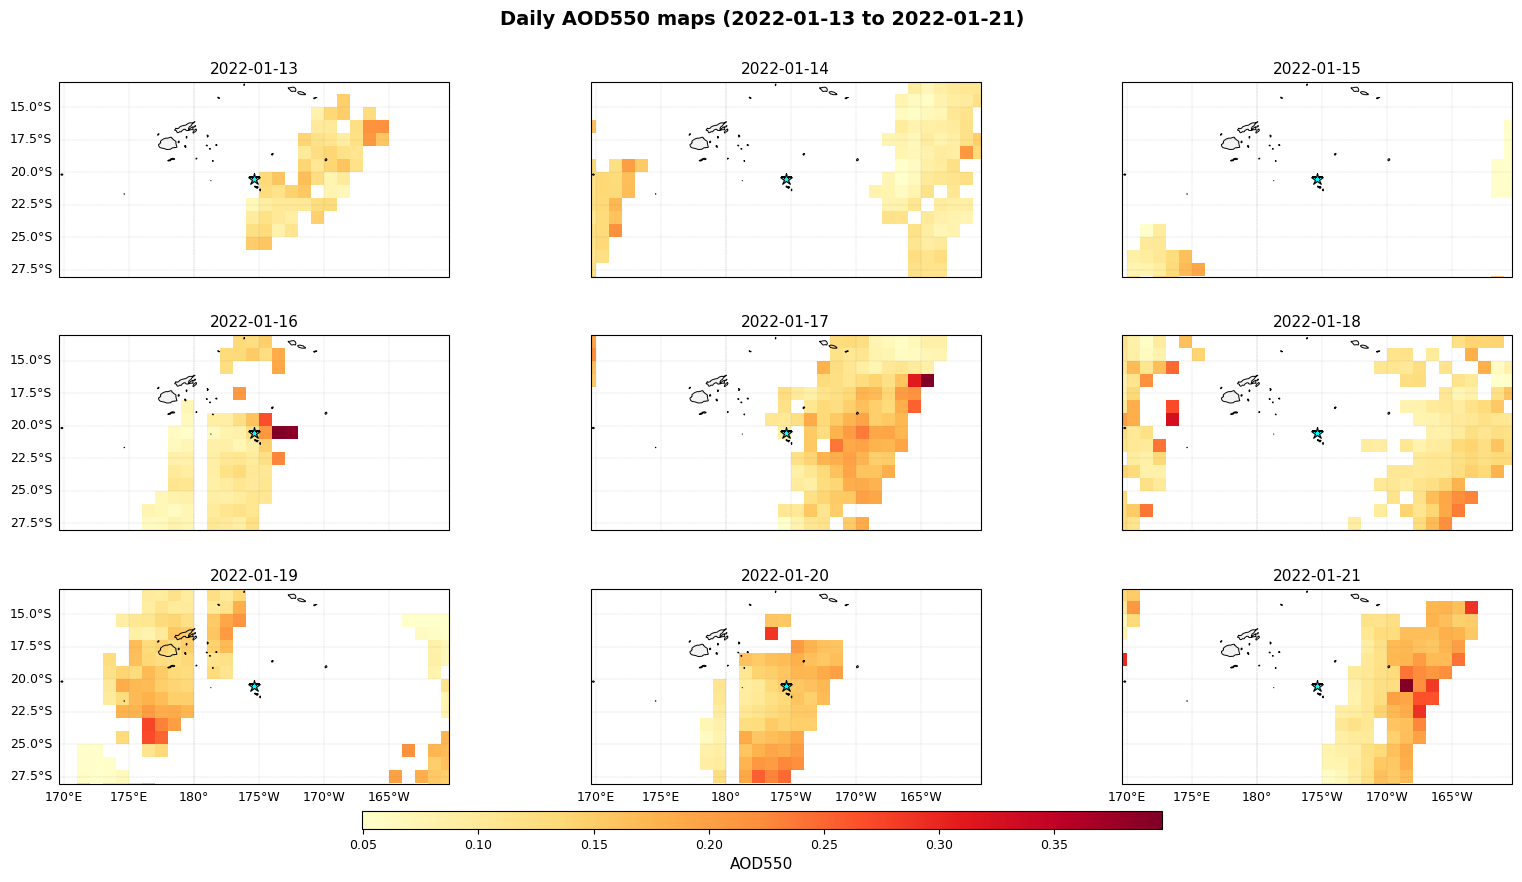

In [32]:
plot_9panel_aod(aod_9, days_9, varname="AOD550", label="AOD550")


*Figure 2.* Daily AOD550 maps for the period 13–21 January 2022 in the Hunga Tonga region.
This 9-panel figure shows the spatial evolution of aerosol optical depth (AOD550) during the days immediately before and after the 15 January 2022 eruption of the Hunga Tonga–Hunga Haʻapai volcano. Each panel represents one day, using a consistent colour scale to allow comparison of AOD magnitude across the sequence.

#### 9-panel map of daily Fine-mode AOD550 before and after the Hunga Tonga eruption (13–21 January 2022)

To complement the total AOD analysis, daily maps of the fine-mode aerosol optical depth (FM_AOD550) were generated for the same 9-day period spanning 13–21 January 2022. These maps isolate the contribution of fine particles allowing a direct comparison with the spatial patterns of total AOD. By examining the fine-mode component alongside the full aerosol load, it becomes possible to assess how much of the detected plume is driven by fine volcanic particles, and how these contributions evolve during the initial dispersion phase after the eruption.

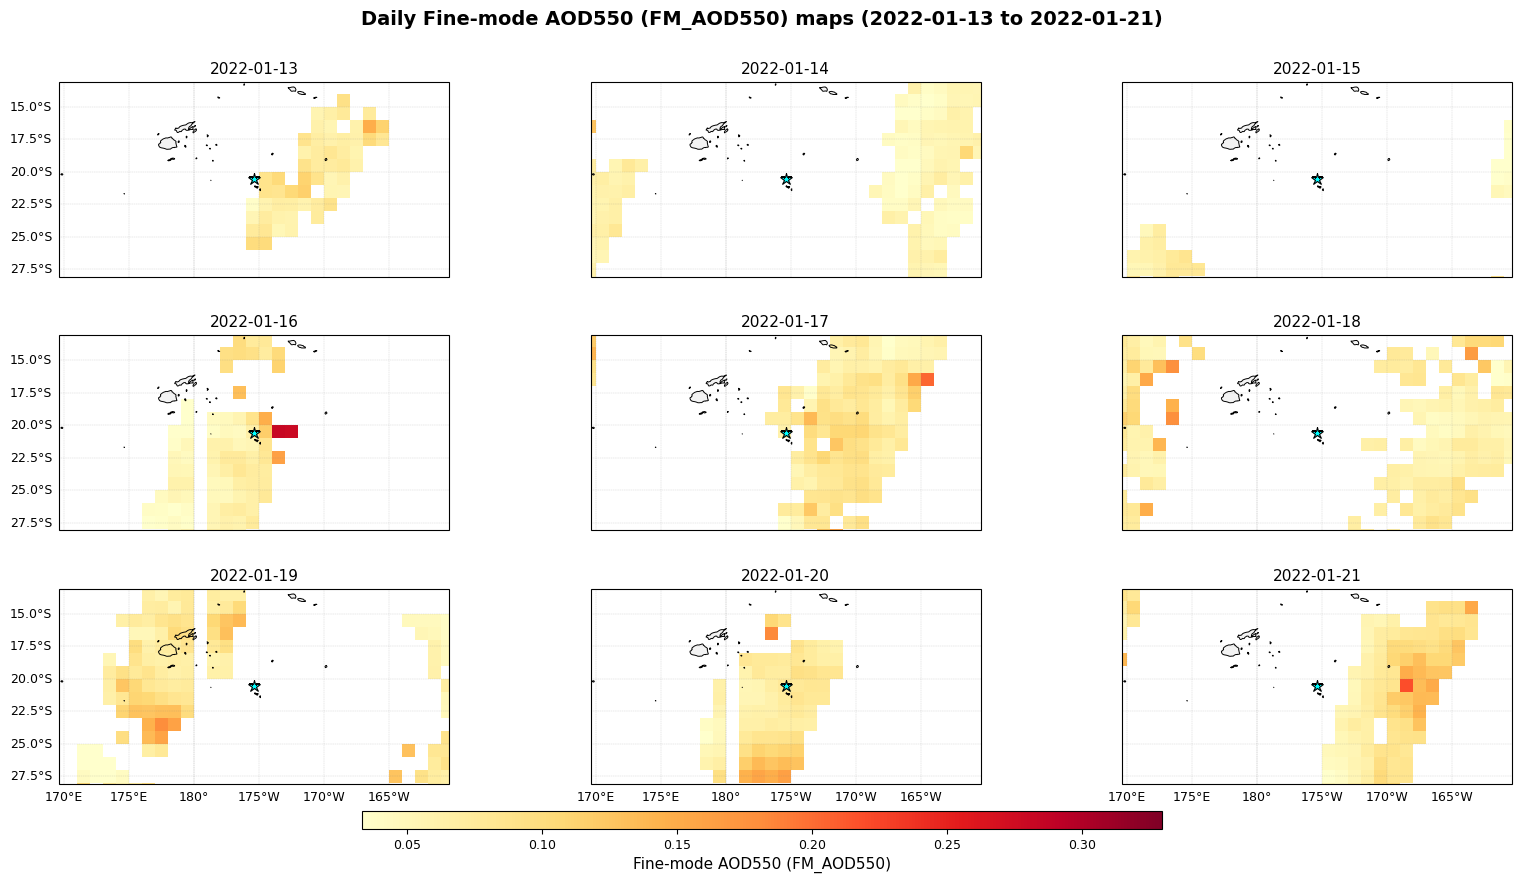

In [33]:
plot_9panel_aod(aod_9, days_9, varname="FM_AOD550", label="Fine-mode AOD550 (FM_AOD550)")


*Figure 3.* Daily fine-mode AOD550 maps for the period 13–21 January 2022 in the Hunga Tonga region.
This 9-panel figure shows the spatial distribution of the fine-mode aerosol optical depth (FM_AOD550) during the days immediately before and after the 15 January 2022 eruption. Each panel corresponds to one day and uses a consistent colour scale to allow comparison of fine-particle abundance across the sequence.

Fine-mode AOD increases on 16 January near the volcano (marked with a star), reflecting the injection of fine ash and sulfate precursors into the atmosphere. Compared to total AOD, the fine-mode AOD is lower and show smaller horizontal gradients.

#### comparison of fine- and coarse-mode aerosol fractions before and after the eruption

For the size-fraction analysis we use a smaller ±1° AOI around the volcano to better represent the near-vent plume. The mean fraction of fine- and coarse-mode aerosol was evaluated for periods immediately before and after the eruption.

In [35]:
# AOI around the volcano
HALFWIN = 1.0

# Subset once
aod_aoi = subset_aoi_antimeridian(aod_df, VOLCANO["lat"], VOLCANO["lon"], HALFWIN)
aod_aoi["time"] = pd.to_datetime(aod_aoi["time"])

def mean_size_fractions(df, start_date, end_date, label):
    """Compute mean fine / coarse fractions for a given period."""
    mask = (df["time"] >= start_date) & (df["time"] <= end_date)
    sub = df[mask].dropna(subset=["AOD550", "FM_AOD550"]).copy()

    sub["fine_frac"]   = sub["FM_AOD550"] / sub["AOD550"]
    sub["coarse_frac"] = 1.0 - sub["fine_frac"]

    mean_fine   = sub["fine_frac"].mean()
    mean_coarse = sub["coarse_frac"].mean()

    print(f"{label}:")
    print(f"  Mean fine-mode fraction :   {mean_fine:.2f}")
    print(f"  Mean coarse-mode fraction : {mean_coarse:.2f}\n")

# before eruption: 13–14 Jan 
mean_size_fractions(aod_aoi, "2022-01-13", "2022-01-14",
                    "Pre-eruption period (13–14 Jan)")

#  immediately after eruption: 16–18 Jan 
mean_size_fractions(aod_aoi, "2022-01-16", "2022-01-18",
                    "Post-eruption period (16–18 Jan)")


Pre-eruption period (13–14 Jan):
  Mean fine-mode fraction :   0.68
  Mean coarse-mode fraction : 0.32

Post-eruption period (16–18 Jan):
  Mean fine-mode fraction :   0.59
  Mean coarse-mode fraction : 0.41



During the pre-eruption period (13–14 January), aerosols in the vicinity of the volcano were dominated by fine particles, with an average fine-mode fraction of 0.68 and a coarse-mode fraction of 0.32. These values are closer to the typical marine and regional aerosol conditions for the considered location, where fine particles (e.g., sulfates, sea-salt submicron modes, transport of other aerosol types at regional scale) represent the largest fraction of the optical depth.
In contrast, during the post-eruption period (16–18 January), the contribution of coarse particles increased. The fine-mode fraction decreased to 0.59, while the coarse-mode fraction increased to 0.41. This shift is consistent with the injection of large volcanic ash particles.
Overall, the comparison indicates a transition toward the increase of the coarser particles following the Hunga Tonga eruption, in line with the expected particle size of volcanic aerosol close to the volcano vent.

(section-4)=
### Take-home messages

• The 9-panel AOD550 maps from 13–21 January show a transition to the preence of a volcanic plume. Low, relatively homogeneous AOD before 15 January is followed by a strong AOD enhancement near Hunga Tonga and subsequent eastward and northeastward transport over the South Pacific.

• The fine-mode AOD550 (FM_AOD) maps exhibit an increase after the eruption, but with a more homogeneous spatial structure than total AOD. 

• The fine-coarse fraction analysis over a ±1° AOI shows a shift in particle size after the eruption. The fine-mode fraction decreases from 0.68 in the pre-eruption period (13–14 January) to 0.59 in the post-eruption period (16–18 January), while the coarse-mode fraction increases from 0.32 to 0.41.

• The increase in coarse-mode fraction in the days immediately following the eruption is consistent with the injection of volcanic ash, which predominantly contributes to the coarse aerosol mode. 

• Despite retrieval limitations likely occurring near very optically thick regions, the combined analysis of AOD, fine-mode AOD, and size fractions demonstrates that satellite-derived aerosol products can be used to characterize both the spatial evolution and the fraction of aerosol particles related to volcanic eruptions in the days surrounding major eruptions.


## ℹ️ If you want to know more
### References

[[1]](https://doi.org/10.3390/rs15102661) Liu, Q., Gui, L., Liu, J., Ventura, G., Yang, Q., Wang, Z., Tang, Z., Tao, M., & Shen, X. (2023). *Multi-Satellite Detection of Long-Range Transport and Transformation of Atmospheric Emissions from the Hunga Tonga–Hunga Ha’apai Volcano*. **Remote Sensing**, 15(10), 2661.

[[2]](https://doi.org/10.1134/S0742046325700010) Guo, M., Wang, C., Bai, J., Gao, Y., Zhang, H., Hou, R., Wang, Q., Zhang, W., Jin, Z., & Huang, H. (2025). *Enlightenment of the Recent Explosive Eruption of Hunga Tonga–Hunga Ha’apai in Tonga*. **Journal of Volcanology and Seismology**, 19(2), 203–214.

[[3]](https://doi.org/10.5194/acp-22-14957-2022) Legras, B., Duchamp, C., Sellitto, P., Podglajen, A., Carboni, E., Siddans, R., Grooß, J.-U., Khaykin, S., & Ploeger, F. (2022). *The evolution and dynamics of the Hunga Tonga–Hunga Ha’apai sulfate aerosol plume in the stratosphere*. **Atmospheric Chemistry and Physics**, 22(22), 14957–14970.